In [188]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import scipy as sp
from scipy.stats import zscore
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import cifti
import nibabel
import statsmodels.api as sm


sb.set()
sb.set(font_scale=2)

In [390]:
# Set output folder 
res_folder = '/Users/mszmb4/dHCP/connectome/results'

#Set input folder
in_folder = '/Users/mszmb4/dHCP/connectome/input_vars'

tracts = ['ar_l', 'ar_r', 'atr_l', 'atr_r', 'cgc_l', 'cgc_r', 'cgh_l', 'cgh_r', 'cst_l', 'cst_r', 'fma', 'fmi', 'for_l', 'for_r', 'ifo_l', 'ifo_r', 'ilf_l', 'ilf_r', 'mcp', 'ml_l', 'ml_r', 'ptr_l', 'ptr_r', 'slf_l', 'slf_r', 'str_l', 'str_r', 'unc_l', 'unc_r']


In [392]:
# Read in dependent variable
# Can be set to: 'area', 'entropy', 'curvature', 'thickness', 'corr_thickness', 'sulc'
var = 'entropy'
y = np.genfromtxt(in_folder + '/' + var + '.txt')

# Read in design matrix
X = pd.read_csv(in_folder + '/design_mat.csv')


In [394]:
# Read and set necessary giftis
if y.shape[0] > 30000:    # Surface metrics are on 32k surfaces, tractography is on 10k
    left_mask = nibabel.load(in_folder + '/week40.L.atlasroi.32k.inv.func.gii').darrays[0].data
    right_mask = nibabel.load(in_folder + '/week40.R.atlasroi.32k.inv.func.gii').darrays[0].data
else:
    left_mask = nibabel.load(in_folder + '/week40.L.atlasroi.10k.shape.gii').darrays[0].data
    right_mask = nibabel.load(in_folder + '/week40.R.atlasroi.10k.shape.gii').darrays[0].data

    
bm = cifti.BrainModel.from_mask(left_mask, name='CortexLeft') + cifti.BrainModel.from_mask(right_mask, name='CortexRight')
sc = cifti.Scalar.from_names(['38','39','40','41','42','43','44'])



In [328]:
# Independent variable description
print('N surface vertices:', y.shape[0])
print('N subjects:', y.shape[1])

# Add regressors
X['prems'] = np.array(X['age_birth'] < 37).astype(int)
X['age_deltas'] = np.array(X['age_scan'] - X['age_birth'])

# Overview of available regressors
X.describe()


N surface vertices: 18795
N subjects: 554


age_scan   age_birth       csf_vol        ven_vol        gm_vol  \
count  554.000000  554.000000  5.540000e+02     554.000000  5.540000e+02   
mean    39.759747   37.335866  5.693310e+05   42364.685921  1.089904e+06   
std      2.991162    4.218358  1.435742e+05   18644.411210  2.918426e+05   
min     29.290000   23.000000  2.076800e+05   18077.000000  2.661600e+05   
25%     38.430000   35.140000  4.742950e+05   31348.250000  9.397225e+05   
50%     40.430000   39.000000  5.655500e+05   38634.500000  1.121850e+06   
75%     41.710000   40.430000  6.448275e+05   47400.750000  1.276900e+06   
max     44.430000   42.290000  1.183700e+06  210090.000000  1.772100e+06   

             wm_vol      qc_snr   qc_cnr400  qc_cnr1000  qc_cnr2600  \
count  5.540000e+02  554.000000  554.000000  554.000000  554.000000   
mean   1.152102e+06   12.565578    0.410235    0.668592    0.561245   
std    1.709405e+05    2.332720    0.072332    0.106736    0.105564   
min    5.781100e+05    5.990000    0.120000    0.170000    0.240000   
25%    1.057900e+06   11.022500    0.370000    0.600000    0.500000   
50%    1.160550e+06   12.620000    0.420000    0.680000    0.560000   
75%    1.260950e+06   14.085000    0.460000    0.740000    0.640000   
max    1.591800e+06   19.170000    0.580000    0.910000    0.830000   

       msm_sulc_corr       prems  age_deltas  
count     554.000000  554.000000  554.000000  
mean        0.846502    0.333935    2.423881  
std         0.027018    0.472043    3.543333  
min         0.565050    0.000000    0.000000  
25%         0.835610    0.000000    0.290000  
50%         0.850550    0.000000    0.860000  
75%         0.862345    1.000000    3.000000  
max         0.899990    1.000000   19.430000

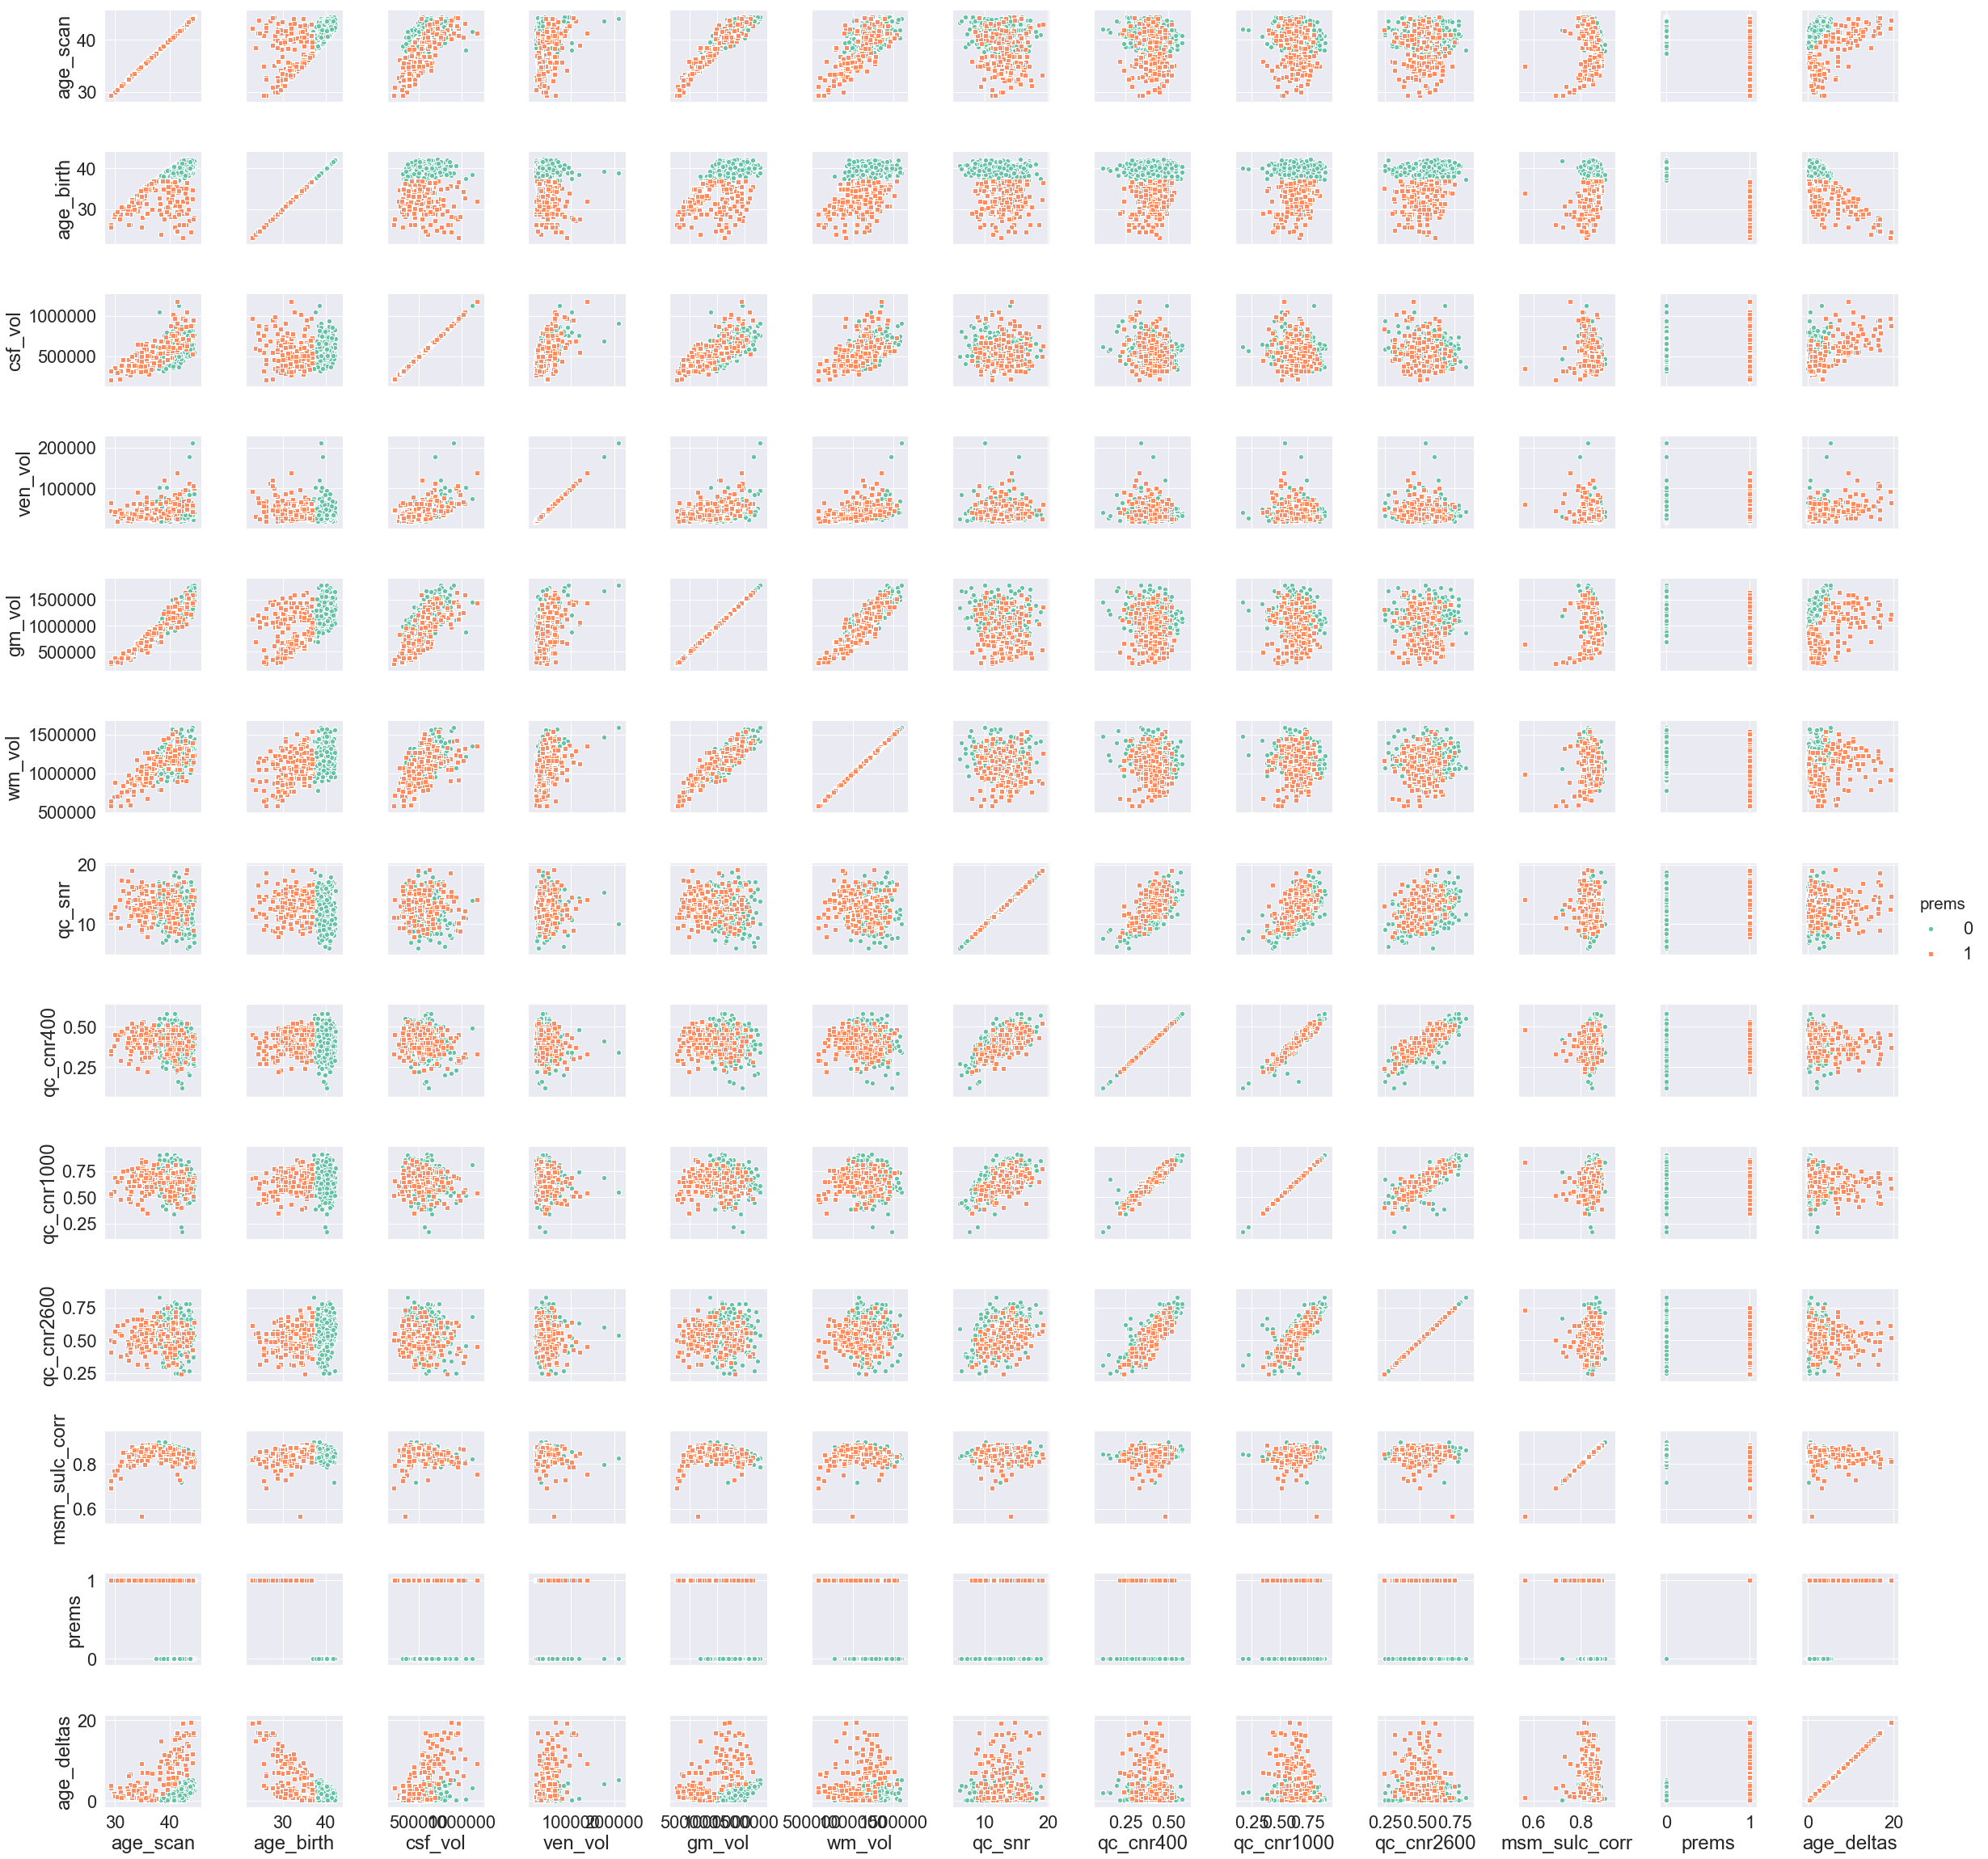

In [329]:
# Design matrix scatter plots
g = sb.PairGrid(data=X, hue='prems', palette="Set2",
                hue_kws={"marker": ["o", "s"]})
g = g.map(plt.scatter, linewidths=1, edgecolor="w", s=40)
g = g.add_legend()

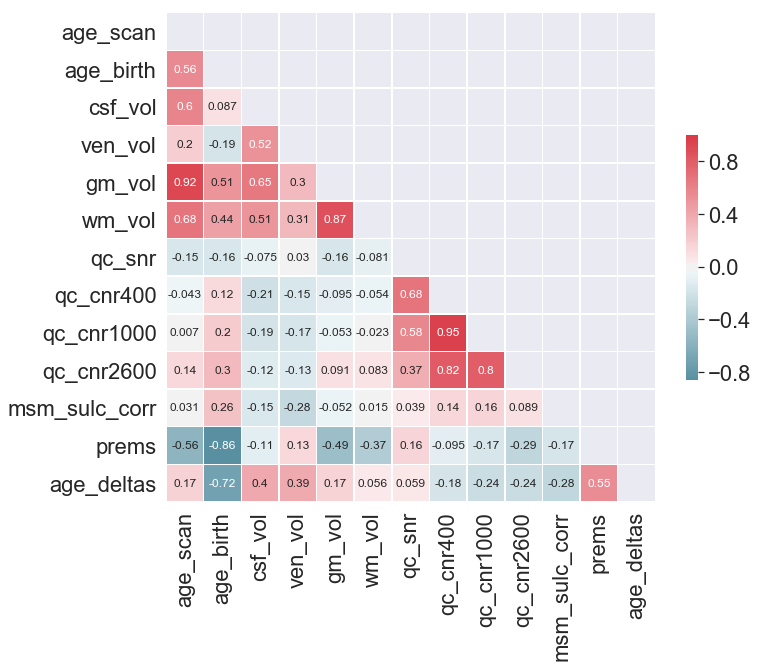

In [330]:
# Compute the correlation matrix
corr = X.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sb.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sb.heatmap(corr, mask=mask, cmap=cmap, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot_kws={"size": 12})

## Surface analysis

In [331]:
# Set up confounds matrix and demean it
conf = np.concatenate((X['wm_vol']+X['gm_vol'],
                       X['qc_snr'],
                       X['qc_cnr400'],
                       X['qc_cnr1000'],
                       X['qc_cnr2600'],
                       X['msm_sulc_corr']), axis=0)
conf = conf.reshape((6, -1)).T

for ii in np.arange(0, 6):
    conf[:, ii] = conf[:, ii] - np.mean(conf[:, ii])



### Model 1

In [340]:
# Model 1: ent = b1 * age_birth + b2 * age_delta + sum(b_i * conf_i)
xx = np.concatenate((X['age_birth'][:, np.newaxis],
                     X['age_deltas'][:, np.newaxis],
                     conf), axis=1)

reg_m1 = LinearRegression(fit_intercept=False, normalize=False).fit(xx, y.T)
pred_m1 = reg_m1.predict(xx) 

# Store regression coefficients
sc = cifti.Scalar.from_names([var + '_model1_b1', var + '_model1_b2'])
cifti.write(res_folder + '/' + var + '_model1_coefs.dscalar.nii', reg_m1.coef_[:,0:2].T, (sc, bm))



In [341]:
# Get BIC for model 1 using statsmodel
BIC_m1 = np.empty(y.shape[0])

for ii in np.arange(0, y.shape[0]):
    results = sm.OLS(y[ii, :], xx).fit()
    BIC_m1[ii] = results.bic



### Model 2

In [342]:
# Model 2: ent = b1 * age_birth + b2_prems * age_delta_prems + b2_term * age_delta_term + sum(b_i * conf_i)
xx = np.concatenate((X['age_birth'][:, np.newaxis],
                     X['age_deltas'][:, np.newaxis],
                     X['age_deltas'][:, np.newaxis],
                     conf), axis=1)
xx[X['age_birth'] >= 37, 1] = 0
xx[X['age_birth'] < 37, 2] = 0

reg_m2 = LinearRegression(fit_intercept=False, normalize=False).fit(xx, y.T)
pred_m2 = reg_m2.predict(xx) 


# Store regression coefficients
sc = cifti.Scalar.from_names([var + '_model2_b1', var + '_model2_b2_prems', var + '_model2_b2_term'])
cifti.write(res_folder + '/' + var + '_model2_coefs.dscalar.nii', reg_m2.coef_[:,0:3].T, (sc, bm))





In [343]:
# Get BIC for model 2 using statsmodel
BIC_m2 = np.empty(y.shape[0])

for ii in np.arange(0, y.shape[0]):
    results = sm.OLS(y[ii, :], xx).fit()
    BIC_m2[ii] = results.bic




In [ ]:
from scipy.stats import gaussian_kde

sb.jointplot(x=reg_m2.coef_[:,0], y=reg.coef_[:,1], kind='reg').set_axis_labels("b1", "b2_prems")
xy = np.vstack([reg_m2.coef_[:,0], reg_m2.coef_[:,1]])
z = gaussian_kde(xy)(xy)
plt.scatter(x=reg_m2.coef_[:,0], y=reg_m2.coef_[:,1], c=np.log(1+z))

sb.jointplot(x=reg_m2.coef_[:,0], y=reg_m2.coef_[:,2], kind='reg').set_axis_labels("b1", "b2_terms")
xy = np.vstack([reg_m2.coef_[:,0], reg_m2.coef_[:,2]])
z = gaussian_kde(xy)(xy)
plt.scatter(x=reg_m2.coef_[:,0], y=reg_m2.coef_[:,2], c=np.log(1+z))

sb.jointplot(x=reg_m2.coef_[:,1], y=reg_m2.coef_[:,2], kind='reg').set_axis_labels("b2_prems", "b2_terms")
xy = np.vstack([reg_m2.coef_[:,1], reg_m2.coef_[:,2]])
z = gaussian_kde(xy)(xy)
plt.scatter(x=reg_m2.coef_[:,1], y=reg_m2.coef_[:,2], c=np.log(1+z))

### Model 3

In [353]:
# Model 3: ent = b1_prems * age_birth_prems + b1_term * age_birth_term + b2_prems * age_delta_prems + b2_term * age_delta_term + sum(b_i * conf_i)
xx = np.concatenate((X['age_birth'][:, np.newaxis],
                     X['age_birth'][:, np.newaxis],
                     X['age_deltas'][:, np.newaxis],
                     X['age_deltas'][:, np.newaxis],
                     conf), axis=1)
xx[X['age_birth'] >= 37, 0] = 0
xx[X['age_birth'] < 37, 1] = 0
xx[X['age_birth'] >= 37, 2] = 0
xx[X['age_birth'] < 37, 3] = 0

reg_m3 = LinearRegression(fit_intercept=False, normalize=False).fit(xx, y.T)
pred_m3 = reg_m3.predict(xx) 


# Store regression coefficients
sc = cifti.Scalar.from_names([var + '_model3_b1_prems', var + '_model3_b1_term', var + '_model3_b2_prems', var + '_model3_b2_term'])

cifti.write(res_folder + '/' + var + '_model3_coefs.dscalar.nii', reg_m3.coef_[:,0:4].T, (sc, bm))



In [354]:
# Get BIC for model 3 using statsmodel
BIC_m3 = np.empty(y.shape[0])

for ii in np.arange(0, y.shape[0]):
    results = sm.OLS(y[ii, :], xx).fit()
    BIC_m3[ii] = results.bic




0.11839372791892111
0.12182440425727381
0.12969893840559021


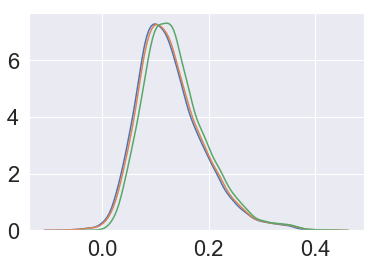

In [355]:
# Get R^2 for the three models
r2_m1 = np.empty(y.shape[0])
r2_m2 = np.empty(y.shape[0])
r2_m3 = np.empty(y.shape[0])


for ii in np.arange(0, y.shape[0]):
    r2_m1[ii] = r2_score(y[ii, :].T, pred_m1[:, ii])
    r2_m2[ii] = r2_score(y[ii, :].T, pred_m2[:, ii])
    r2_m3[ii] = r2_score(y[ii, :].T, pred_m3[:, ii])
   
sb.kdeplot(r2_m1, shade=False)
sb.kdeplot(r2_m2, shade=False)
sb.kdeplot(r2_m3, shade=False)


print(np.median(r2_m1))
print(np.median(r2_m2))
print(np.median(r2_m3))




-5.323099511577652
-3.8631842435048114
-7.776884373912935


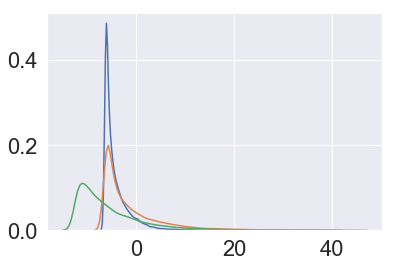

In [356]:
# BIC differences

sb.kdeplot(BIC_m1-BIC_m2, shade=False)
sb.kdeplot(BIC_m2-BIC_m3, shade=False)
sb.kdeplot(BIC_m1-BIC_m3, shade=False)


print(np.median(BIC_m1-BIC_m2))
print(np.median(BIC_m2-BIC_m3))
print(np.median(BIC_m1-BIC_m3))


# MODEL 1 IS BEST!!! :(

## WM entropy analysis

In [395]:
wm_entropy = np.genfromtxt(in_folder + '/wm_entropy.txt')
wm_atlas = nibabel.load(in_folder + '/40_atlas_lowres.nii.gz')

wm_mask = nibabel.load(in_folder + '/wm_mask_stdw40_lowres.nii.gz')  
wm_coords = np.genfromtxt(in_folder + '/wm_coords.txt')

In [361]:
# Model 1: ent = b1 * age_birth + b2 * age_delta + sum(b_i * conf_i)
xx = np.concatenate((X['age_birth'][:, np.newaxis],
                     X['age_deltas'][:, np.newaxis],
                     conf), axis=1)

reg = LinearRegression(fit_intercept=False, normalize=False).fit(xx, wm_entropy.T)
# Get BIC for model 1 using statsmodel
BIC_m1 = np.empty(wm_entropy.shape[0])

for ii in np.arange(0, wm_entropy.shape[0]):
    results = sm.OLS(wm_entropy[ii, :], xx).fit()
    BIC_m1[ii] = results.bic



# Store regression coefficients (volumes)
for i in np.arange(0, 2):
    cc = 0
    coef_vol = 0*wm_mask.get_data()
    for x, y, z in (wm_coords-1).astype(int):
        coef_vol[x, y, z] = reg.coef_[cc, i]
        cc = cc + 1

    vol = nibabel.Nifti1Image(coef_vol, 
                          wm_mask.get_affine(), 
                          wm_mask.header)
    nibabel.save(vol, res_folder + '/wm_ent_model1_b' + str(i) + '.nii.gz')






/Users/mszmb4/miniconda3/envs/myfslpython/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:846: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/mszmb4/miniconda3/envs/myfslpython/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: get_affine method is deprecated.
Please use the ``img.affine`` property instead.

* deprecated from version: 2.1
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0


In [362]:
# Model 2: ent = b1 * age_birth + b2_prems * age_delta_prems + b2_term * age_delta_term + sum(b_i * conf_i)
xx = np.concatenate((X['age_birth'][:, np.newaxis],
                     X['age_deltas'][:, np.newaxis],
                     X['age_deltas'][:, np.newaxis],
                     conf), axis=1)
xx[X['age_birth'] >= 37, 1] = 0
xx[X['age_birth'] < 37, 2] = 0


reg = LinearRegression(fit_intercept=False, normalize=False).fit(xx, wm_entropy.T)
# Get BIC for model 2 using statsmodel
BIC_m2 = np.empty(wm_entropy.shape[0])

for ii in np.arange(0, wm_entropy.shape[0]):
    results = sm.OLS(wm_entropy[ii, :], xx).fit()
    BIC_m2[ii] = results.bic


# Store regression coefficients (volumes)
for i in np.arange(0, 3):
    cc = 0
    coef_vol = 0*wm_mask.get_data()
    for x, y, z in (wm_coords-1).astype(int):
        coef_vol[x, y, z] = reg.coef_[cc, i]
        cc = cc + 1

    vol = nibabel.Nifti1Image(coef_vol, 
                          wm_mask.get_affine(), 
                          wm_mask.header)
    nibabel.save(vol, res_folder + '/wm_ent_model2_b' + str(i) + '.nii.gz')





/Users/mszmb4/miniconda3/envs/myfslpython/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:846: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/mszmb4/miniconda3/envs/myfslpython/lib/python3.6/site-packages/ipykernel_launcher.py:28: DeprecationWarning: get_affine method is deprecated.
Please use the ``img.affine`` property instead.

* deprecated from version: 2.1
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0


In [363]:
# Model 3: ent = b1_prems * age_birth_prems + b1_term * age_birth_term + b2_prems * age_delta_prems + b2_term * age_delta_term + sum(b_i * conf_i)
xx = np.concatenate((X['age_birth'][:, np.newaxis],
                     X['age_birth'][:, np.newaxis],
                     X['age_deltas'][:, np.newaxis],
                     X['age_deltas'][:, np.newaxis],
                     conf), axis=1)
xx[X['age_birth'] >= 37, 0] = 0
xx[X['age_birth'] < 37, 1] = 0
xx[X['age_birth'] >= 37, 2] = 0
xx[X['age_birth'] < 37, 3] = 0



reg = LinearRegression(fit_intercept=False, normalize=False).fit(xx, wm_entropy.T)
# Get BIC for model 3 using statsmodel
BIC_m3 = np.empty(wm_entropy.shape[0])

for ii in np.arange(0, wm_entropy.shape[0]):
    results = sm.OLS(wm_entropy[ii, :], xx).fit()
    BIC_m3[ii] = results.bic


# Store regression coefficients (volumes)
for i in np.arange(0, 3):
    cc = 0
    coef_vol = 0*wm_mask.get_data()
    for x, y, z in (wm_coords-1).astype(int):
        coef_vol[x, y, z] = reg.coef_[cc, i]
        cc = cc + 1

    vol = nibabel.Nifti1Image(coef_vol, 
                          wm_mask.get_affine(), 
                          wm_mask.header)
    nibabel.save(vol, res_folder + '/wm_ent_model3_b' + str(i) + '.nii.gz')






/Users/mszmb4/miniconda3/envs/myfslpython/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:846: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/mszmb4/miniconda3/envs/myfslpython/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: get_affine method is deprecated.
Please use the ``img.affine`` property instead.

* deprecated from version: 2.1
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0


/Users/mszmb4/miniconda3/envs/myfslpython/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in subtract
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/mszmb4/miniconda3/envs/myfslpython/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/mszmb4/miniconda3/envs/myfslpython/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/mszmb4/miniconda3/envs/myfslpython/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in subtract
  after removing the cwd from sys.path.
/Users/mszmb4/miniconda3/envs/myfslpython/lib/python3.6/site-packages/ipykernel_launcher.py:5: Runtim

nan
nan
nan


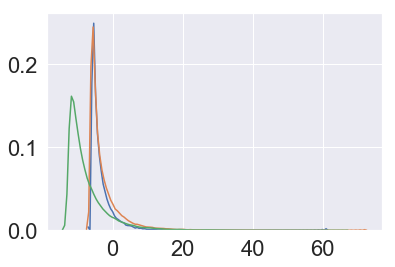

In [364]:
# BIC differences

sb.kdeplot(BIC_m1-BIC_m2, shade=False)
sb.kdeplot(BIC_m2-BIC_m3, shade=False)
sb.kdeplot(BIC_m1-BIC_m3, shade=False)


print(np.median(BIC_m1-BIC_m2))
print(np.median(BIC_m2-BIC_m3))
print(np.median(BIC_m1-BIC_m3))


# MODEL 1 IS BEST!!! :(

### Parcellate cortex based on blueprints

In [366]:
# Load GM blueprints
tmp = np.genfromtxt(in_folder + '/all_gmXtracts.txt')


TypeError: data type not understood

In [372]:
# Reshape blueprint matrix to [GM_vertices X Tracts X N_subjects]
bprints = np.empty((18795, 29, 554))

for i in np.arange(1, 30):
    bprints[:, i-1, :] = tmp[(i-1)*18795:i*18795, :]

In [382]:
avg_bp_w40 = np.mean(bprints[:, :, (np.round(X['age_scan'])==40) & (np.round(X['age_birth'])>39.5)], axis=2)

In [386]:
# Use a winner-takes-all approach
parcel = np.empty(avg_bp_w40.shape[0])
for i in np.arange(0, avg_bp_w40.shape[0]):
    parcel[i] = 1+np.argmax(avg_bp_w40[i, :])

# Store regression coefficients
sc = cifti.Scalar.from_names(['tracts_parcel'])
cifti.write(res_folder + '/bp_parcels.dscalar.nii', parcel[:, np.newaxis].T, (sc, bm))

